In [ ]:
!pip install -U langgraph
!pip install langchain-openai

In [2]:
import os
os.environ["OPENAI_API_KEY"] = ''


In [4]:
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode

In [10]:
@tool
def get_weather(location:str):
  """Call to get the weather"""
  if location in ["서울","인천"]:
    return "its 60도"
  else:
    return "90도야"

@tool
def get_coolest_cities():
  """시원한 도시 얻기"""
  return "서울","충남"


tools  = [get_weather, get_coolest_cities]
tool_node = ToolNode(tools)



In [12]:
from langchain_openai import ChatOpenAI
model_with_tools = ChatOpenAI(model = "gpt-4o-mini").bind_tools(tools) ##################3 바인드 tools


In [14]:
model_with_tools.invoke("서울날씨좀").tool_calls

[{'name': 'get_weather',
  'args': {'location': '서울'},
  'id': 'call_RbhZ7AOn936G8BSQOwsbVSO1',
  'type': 'tool_call'}]

In [13]:
model_with_tools.invoke("한국에서 추운 도시는?").tool_calls

[{'name': 'get_coolest_cities',
  'args': {},
  'id': 'call_GAPJ8kgovJvgO4oXdiym4PQU',
  'type': 'tool_call'}]

In [15]:
tool_node.invoke({"messages":[model_with_tools.invoke("서울날씨좀")]})

{'messages': [ToolMessage(content='its 60도', name='get_weather', tool_call_id='call_DSMZPu9S0K3G8Ys9Yn6Ok2rW')]}

In [16]:
tool_node.invoke({"messages":[model_with_tools.invoke("으슬으슬한 도시는?")]})

{'messages': [ToolMessage(content='["서울", "충남"]', name='get_coolest_cities', tool_call_id='call_tlkc7Cbte9gwjl6MLdZ2qhk5')]}

In [17]:
tool_node.invoke({"messages":[model_with_tools.invoke("대통령 누구뽑지?")]})

{'messages': []}

In [19]:
from typing import Annotated, Literal, TypedDict
from langchain_core.messages import HumanMessage
from langchain_core.tools import tool
from langgraph.graph import END, START, StateGraph, MessagesState

from langgraph.prebuilt import ToolNode
tools  = [get_weather, get_coolest_cities]
tool_node = ToolNode(tools)


# 메시지 상태를 받아 다음 스텝을 판단하는 조건 함수
def should_continue(state: MessagesState) -> Literal["tools", END]:
    messages = state["messages"]                     # 현재까지의 메시지 상태 불러오기
    last_message = messages[-1]                      # 가장 마지막 메시지를 가져옴

    # 마지막 메시지에 tool_call 정보가 있으면, 'tools' 노드로 이동
    if last_message.tool_calls:
        return "tools"

    # 아니면 종료
    return END

# 모델을 호출하여 응답을 생성하는 함수 노드
def call_model(state: MessagesState):
    messages = state["messages"]
    response = model_with_tools.invoke(messages)     # LLM 호출
    return {"messages": [response]}                  # 응답 메시지를 리스트로 반환

workflow = StateGraph(MessagesState)

# 'agent' 노드에 모델 호출 함수 연결
workflow.add_node("agent", call_model)

# 'tools' 노드에 도구 처리 함수(tool_node) 연결
workflow.add_node("tools", tool_node)

# 그래프 시작 지점을 'agent' 노드로 설정
workflow.add_edge(START, "agent")

# 조건 분기 설정:
# 'agent' 노드 실행 후, should_continue() 함수 결과에 따라 다음 노드 결정
workflow.add_conditional_edges(
    "agent",
    should_continue,
)

# 도구 실행 후 다시 'agent'로 돌아가게 설정 (반복 가능)
workflow.add_edge("tools", "agent")

# 그래프 최종 컴파일
app = workflow.compile()


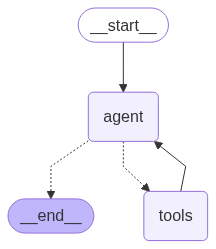

In [22]:
# 그래프 시각화
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))


In [23]:
final_state = app.invoke(
    {"messages": [HumanMessage(content ="일산 날씨좀")]}
)
final_state["messages"][-1].content

'현재 일산의 기온은 90도입니다. 매우 더운 날씨입니다! 추가적인 날씨 정보가 필요하시면 말씀해 주세요.'

In [26]:
# example with a multiple tool calls in succession
for chunk in app.stream(
    {"messages": [("human", "가장 추운 도시의 날씨는 어때?")]},
    stream_mode="values",
):
    chunk["messages"][-1].pretty_print()


================================ Human Message =================================

가장 추운 도시의 날씨는 어때?
================================== Ai Message ==================================
Tool Calls:
  get_coolest_cities (call_zFJztBPvAwbLKSR3cImXorkH)
 Call ID: call_zFJztBPvAwbLKSR3cImXorkH
  Args:
================================= Tool Message =================================
Name: get_coolest_cities

["서울", "충남"]
================================== Ai Message ==================================
Tool Calls:
  get_weather (call_UBype7q0HtlNs5x8bfSuJRUD)
 Call ID: call_UBype7q0HtlNs5x8bfSuJRUD
  Args:
    location: 서울
  get_weather (call_vyqVNHqLyOSjLFlpMEL1Em1o)
 Call ID: call_vyqVNHqLyOSjLFlpMEL1Em1o
  Args:
    location: 충남
================================= Tool Message =================================
Name: get_weather

90도야
================================== Ai Message ==================================

가장 추운 도시인 서울의 날씨는 약 60도(화씨)이며, 충남은 약 90도(화씨)입니다. 서울이 충남보다 상대적으로 더 시원한 날씨를 보이고 있습니다.
